In [ ]:
import pandas as pd
from tqdm.notebook import tqdm 
import sys
path_utils = 'C:/Users/gianl/Desktop/Gi/Supsi/Vaccines_Discussion_Italy/tweet_utils'
sys.path.append(path_utils)
import utils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates


In [ ]:
communities = pd.read_csv(r"..\Files\networks\louvain.csv")
merged_louvain_right = pd.DataFrame()
merged_louvain_left = pd.DataFrame()
merged_louvain_influencer = pd.DataFrame()
merged_louvain_newspaper = pd.DataFrame()
total_len = 0
for chunk in tqdm(pd.read_csv(r"..\Files\Tweets\tweets.csv", lineterminator="\n", low_memory=False,
                        encoding="utf-8", chunksize=100000)):
    total_len += len(chunk)
    merged_louvain = communities.merge(chunk, left_on="name", right_on="user_screen_name", how="right")
    merged_louvain_right =  pd.concat([merged_louvain_right, merged_louvain[merged_louvain["community"]==4]], ignore_index=True)
    merged_louvain_left = pd.concat([merged_louvain_left, merged_louvain[merged_louvain["community"]==0]], ignore_index=True)
    merged_louvain_influencer = pd.concat([merged_louvain_influencer, merged_louvain[merged_louvain["community"]==2]], ignore_index=True)
    merged_louvain_newspaper = pd.concat([merged_louvain_newspaper, merged_louvain[merged_louvain["community"]==3]], ignore_index=True)

In [ ]:
cred_user = pd.read_csv(r"../Files/Tweets/result_cred_score_thresh_10.csv", lineterminator="\n",
                       usecols=["user_screen_name","number_of_urls","HIGH", "LOW", "UNKW", "SOCIAL", "conspiracy_score"])
merged_louvain_right = merged_louvain_right.merge(cred_user, on="user_screen_name", how="left")
merged_louvain_left = merged_louvain_left.merge(cred_user, on="user_screen_name", how="left")
merged_louvain_influencer = merged_louvain_influencer.merge(cred_user, on="user_screen_name", how="left")
merged_louvain_newspaper = merged_louvain_newspaper.merge(cred_user, on="user_screen_name", how="left")


In [ ]:
user_tox = pd.read_csv("../Files/user_toxicity.csv")
user_tox.rename(columns = {'name':'user_screen_name'}, inplace = True)
merged_louvain_right = merged_louvain_right.merge(user_tox, on="user_screen_name", how="left")
merged_louvain_left = merged_louvain_left.merge(user_tox, on="user_screen_name", how="left")
merged_louvain_influencer = merged_louvain_influencer.merge(user_tox, on="user_screen_name", how="left")
merged_louvain_newspaper = merged_louvain_newspaper.merge(user_tox, on="user_screen_name", how="left")

In [ ]:
print(len(merged_louvain_right))
print(len(merged_louvain_left))
print(len(merged_louvain_influencer))
print(len(merged_louvain_newspaper))
print(total_len - (len(merged_louvain_right) + len(merged_louvain_left) + len(merged_louvain_influencer) + len(merged_louvain_newspaper)))

In [ ]:
from IPython.display import Image
Image(r"C:\Users\gianl\Desktop\Gi\Supsi\Vaccines_Discussion_Italy\Italian\Files\flow_comm_small.png")

In [ ]:
print(f"Right community over total: {round(len(merged_louvain_right)/total_len,3)*100}%")
print(f"Left community over total: {round(len(merged_louvain_left)/total_len,4)*100}%")
print(f"Influencer community over total: {round(len(merged_louvain_influencer)/total_len,4)*100}%")
print(f"Newspaper community over total: {round(len(merged_louvain_newspaper)/total_len,4)*100}%")
print(f"{round((len(merged_louvain_right) + len(merged_louvain_left) + len(merged_louvain_influencer) + len(merged_louvain_newspaper))/total_len,2)*100}% of total")

In [ ]:
def do_someting(df, dataset_name):
    x = utils.split(df)
    labels = list(x.keys())
    values = list(x.values())
    utils.print_pie_chart4(f"Activities of {dataset_name}", labels, values)
    lst_hashtags = ["vaccino", "vaccini", "COVID19", "Covid19", "Covid_19", "covid", "covid19",
                    "VaccinoAntiCovid", "coronavirus", "vaccinoCovid", "Covid", "Vaccini", "Coronavirus",
                   "Vaccino", "vaccinazioni", "COVID", "vaccinazione", "COVIDー19"]
    hashtags = utils.hashtag_extraction(df)
    hashtags = [i for i in hashtags if i not in lst_hashtags]
    val = pd.Series(hashtags).value_counts().sort_values(ascending=False)
    fig = plt.figure()
    ax = val[:15].plot(kind='barh', color='green')
    ax.set_title(f'Most HASHTAGS shared by {dataset_name}')
    ax.invert_yaxis()
    plt.show()
    x = utils.extract_domain_list(df)
    urls = []
    lst_not_plot = ["dlvr.it", "twitter.com", "tinyurl.com", "trib.al", "bit.ly", "ow.ly"]
    cont = 0
    for i in x:
        if i != []:
            for j in i:
                if (j not in lst_not_plot):
                    if "youtu.be" in j:
                        j = "youtube.com"
                    urls.append(j)
    val = pd.Series(urls).value_counts().sort_values(ascending=False)
    fig = plt.figure()
    ax = val[:15].plot(kind='barh', color='green')
    ax.set_title(f'Most URLS shared by {dataset_name}')
    ax.invert_yaxis()
    plt.show()
    val = pd.Series(df["user_screen_name"]).value_counts().sort_values(ascending=False)
    fig = plt.figure()
    ax = val[:15].plot(kind='barh', color='green')
    ax.set_title(f'Most ACTIVE users from {dataset_name}')
    ax.invert_yaxis()
    plt.show()
    # matplotlib histogram
    plt.hist(df['toxicity_score'], color = 'blue', edgecolor = 'black', bins=20)
    # Add labels
    plt.title(f'Histogram of Toxicity for {dataset_name}')
    plt.xlabel('Value')
    plt.ylabel('Toxicity score')
    df["date"] = [utils.process_datetime(i) for i in tqdm(df["created_at"])]
    df['dates']= df[["toxicity_score","date"]].groupby('date').transform('mean')
    df_for_plot = df.drop_duplicates(subset='date')
    fig, ax = plt.subplots(figsize=(25, 10))
    plt.title(f'Toxicity score of {dataset_name}', fontsize=18)
    df_for_plot.sort_values(by=["date"], ascending=True, inplace=True)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('# of Tweets', fontsize=14)
    plt.plot(df_for_plot['date'], df_for_plot['dates'], c='b', label='Toxicity Score')
    # set monthly locator
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    # set formatter
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    # set font and rotation for date tick labels
    plt.xticks(rotation='vertical', fontsize = 8)
    plt.legend(loc='upper left', fontsize=13);
    # plt.axvline(x="2021-03-09")
    plt.grid()
    plt.show()
    df['dates']= df[["conspiracy_score","date"]].groupby('date').transform('mean')
    df_for_plot = df.drop_duplicates(subset='date')
    fig, ax = plt.subplots(figsize=(25, 10))
    plt.title(f'Conspiracy score of {dataset_name}', fontsize=18)
    df_for_plot.sort_values(by=["date"], ascending=True, inplace=True)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('# of Tweets', fontsize=14)
    plt.plot(df_for_plot['date'], df_for_plot['dates'], c='r', label='Conspiracy Score')
    # set monthly locator
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    # set formatter
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    # set font and rotation for date tick labels
    plt.xticks(rotation='vertical', fontsize = 8)
    plt.legend(loc='upper left', fontsize=13);
    # plt.axvline(x="2021-03-09")
    plt.grid()
    plt.show()

# Right-based community

In [ ]:
do_someting(merged_louvain_right, "Right community")

# Left-based

In [ ]:
do_someting(merged_louvain_left, "Left community")

 # Influencer-based

In [ ]:
do_someting(merged_louvain_influencer, "Influencer community")

# Newspaper-based

In [ ]:
do_someting(merged_louvain_newspaper, "Newspaper community")

# Conspiracy score

In [ ]:
plt.hist([merged_louvain_left["conspiracy_score"],
          merged_louvain_right["conspiracy_score"],
          merged_louvain_influencer["conspiracy_score"],
          merged_louvain_newspaper["conspiracy_score"]],
          label=['Dem community', 'Cons community', "Influencer community", "Newspaper community"])
plt.legend(loc='upper right')
plt.title("Value of Conspiracy score (logarithmic scale)")
plt.yscale('log', nonposy='clip')
plt.xlabel("Conspiracy score")
plt.rcParams["figure.figsize"] = (14,5)
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
data = pd.DataFrame({"Right": merged_louvain_right["conspiracy_score"], "Left": merged_louvain_left["conspiracy_score"],
                    "Influencer":merged_louvain_influencer["conspiracy_score"], "Newspaper":merged_louvain_newspaper["conspiracy_score"]})

ax = data[['Right', 'Left', "Influencer", "Newspaper"]].plot(kind='box', title='Boxplot conspiracy',  showfliers=False)

# Display the plot
plt.show()

# Toxicity

In [ ]:
print(np.mean(merged_louvain_right["toxicity_score"]))
print(np.mean(merged_louvain_left["toxicity_score"]))
print(np.mean(merged_louvain_influencer["toxicity_score"]))
print(np.mean(merged_louvain_newspaper["toxicity_score"]))

In [ ]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
data = pd.DataFrame({"Right": merged_louvain_right["toxicity_score"], "Left": merged_louvain_left["toxicity_score"],
                    "Influencer":merged_louvain_influencer["toxicity_score"], "Newspaper":merged_louvain_newspaper["toxicity_score"]})

ax = data[['Right', 'Left', "Influencer", "Newspaper"]].plot(kind='box', title='Boxplot Toxicity',  showfliers=False)

# Display the plot
plt.show()

In [136]:
print(len(merged_louvain_right))
print(len(merged_louvain_left))
print(len(merged_louvain_influencer))
print(len(merged_louvain_newspaper))
print(total_len - (len(merged_louvain_right) + len(merged_louvain_left) + len(merged_louvain_influencer) + len(merged_louvain_newspaper)))

1601824
1215008
228173
561744
446452


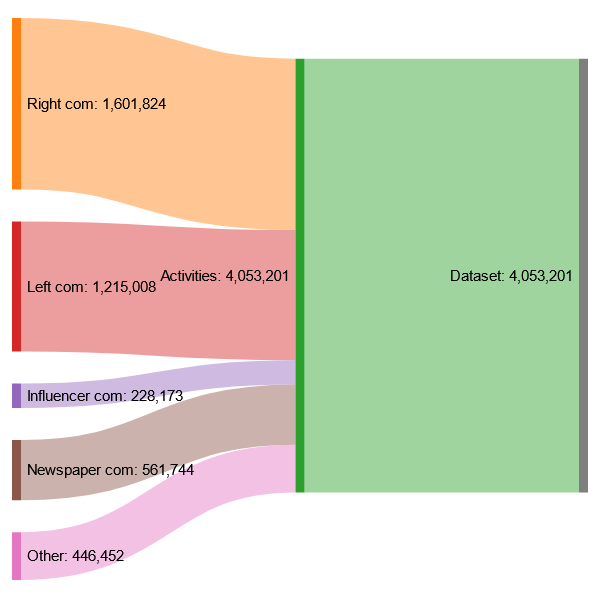

In [143]:
from IPython.display import Image
Image(r"C:\Users\gianl\Desktop\Gi\Supsi\Vaccines_Discussion_Italy\Italian\Files\flow_comm_small.png")

In [123]:
print(f"Right community over total: {round(len(merged_louvain_right)/total_len,3)*100}%")
print(f"Left community over total: {round(len(merged_louvain_left)/total_len,4)*100}%")
print(f"Influencer community over total: {round(len(merged_louvain_influencer)/total_len,4)*100}%")
print(f"Newspaper community over total: {round(len(merged_louvain_newspaper)/total_len,4)*100}%")
print(f"{round((len(merged_louvain_right) + len(merged_louvain_left) + len(merged_louvain_influencer) + len(merged_louvain_newspaper))/total_len,2)*100}% of total")

Right community over total: 39.5%
Left community over total: 29.98%
Influencer community over total: 5.63%
Newspaper community over total: 13.86%
89.0% of total


In [130]:
def do_someting(df, dataset_name):
    x = utils.split(df)
    labels = list(x.keys())
    values = list(x.values())
    utils.print_pie_chart4(f"Activities of {dataset_name}", labels, values)
    lst_hashtags = ["vaccino", "vaccini", "COVID19", "Covid19", "Covid_19", "covid", "covid19",
                    "VaccinoAntiCovid", "coronavirus", "vaccinoCovid", "Covid", "Vaccini", "Coronavirus",
                   "Vaccino", "vaccinazioni", "COVID", "vaccinazione", "COVIDー19"]
    hashtags = utils.hashtag_extraction(df)
    hashtags = [i for i in hashtags if i not in lst_hashtags]
    val = pd.Series(hashtags).value_counts().sort_values(ascending=False)
    fig = plt.figure()
    ax = val[:15].plot(kind='barh', color='green')
    ax.set_title(f'Most HASHTAGS shared by {dataset_name}')
    ax.invert_yaxis()
    plt.show()
    x = utils.extract_domain_list(df)
    urls = []
    lst_not_plot = ["dlvr.it", "twitter.com", "tinyurl.com", "trib.al", "bit.ly", "ow.ly"]
    cont = 0
    for i in x:
        if i != []:
            for j in i:
                if (j not in lst_not_plot):
                    if "youtu.be" in j:
                        j = "youtube.com"
                    urls.append(j)
    val = pd.Series(urls).value_counts().sort_values(ascending=False)
    fig = plt.figure()
    ax = val[:15].plot(kind='barh', color='green')
    ax.set_title(f'Most URLS shared by {dataset_name}')
    ax.invert_yaxis()
    plt.show()
    val = pd.Series(df["user_screen_name"]).value_counts().sort_values(ascending=False)
    fig = plt.figure()
    ax = val[:15].plot(kind='barh', color='green')
    ax.set_title(f'Most ACTIVE users from {dataset_name}')
    ax.invert_yaxis()
    plt.show()
    # matplotlib histogram
    plt.hist(df['toxicity_score'], color = 'blue', edgecolor = 'black', bins=20)
    # Add labels
    plt.title(f'Histogram of Toxicity for {dataset_name}')
    plt.xlabel('Value')
    plt.ylabel('Toxicity score')
    df["date"] = [utils.process_datetime(i) for i in tqdm(df["created_at"])]
    df['dates']= df[["toxicity_score","date"]].groupby('date').transform('mean')
    df_for_plot = df.drop_duplicates(subset='date')
    fig, ax = plt.subplots(figsize=(25, 10))
    plt.title(f'Toxicity score of {dataset_name}', fontsize=18)
    df_for_plot.sort_values(by=["date"], ascending=True, inplace=True)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('# of Tweets', fontsize=14)
    plt.plot(df_for_plot['date'], df_for_plot['dates'], c='b', label='Toxicity Score')
    # set monthly locator
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    # set formatter
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    # set font and rotation for date tick labels
    plt.xticks(rotation='vertical', fontsize = 8)
    plt.legend(loc='upper left', fontsize=13);
    # plt.axvline(x="2021-03-09")
    plt.grid()
    plt.show()
    df['dates']= df[["conspiracy_score","date"]].groupby('date').transform('mean')
    df_for_plot = df.drop_duplicates(subset='date')
    fig, ax = plt.subplots(figsize=(25, 10))
    plt.title(f'Conspiracy score of {dataset_name}', fontsize=18)
    df_for_plot.sort_values(by=["date"], ascending=True, inplace=True)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('# of Tweets', fontsize=14)
    plt.plot(df_for_plot['date'], df_for_plot['dates'], c='r', label='Conspiracy Score')
    # set monthly locator
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    # set formatter
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    # set font and rotation for date tick labels
    plt.xticks(rotation='vertical', fontsize = 8)
    plt.legend(loc='upper left', fontsize=13);
    # plt.axvline(x="2021-03-09")
    plt.grid()
    plt.show()

# Right-based community

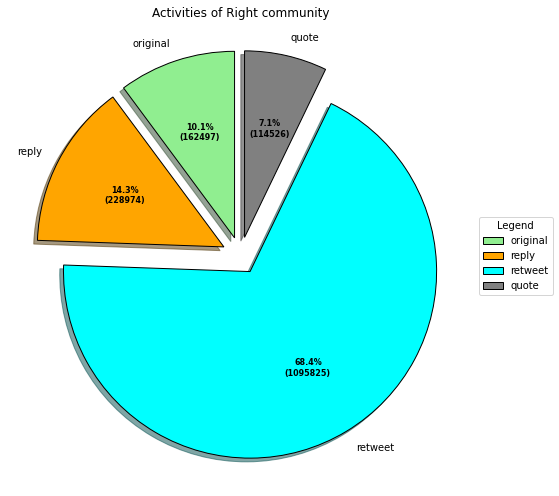

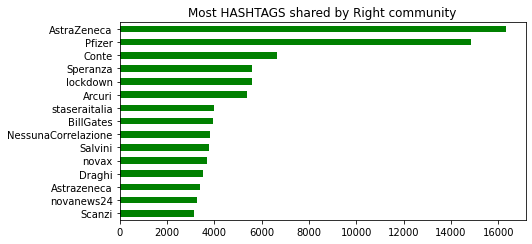

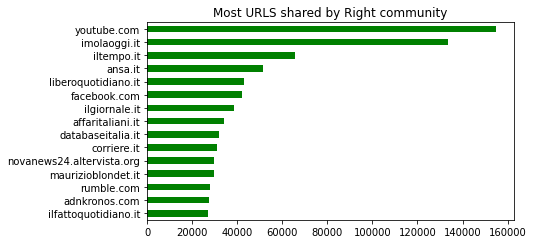

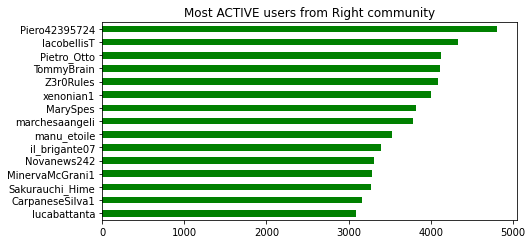

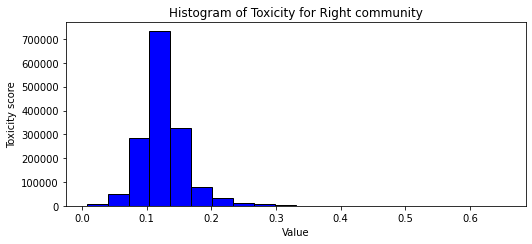

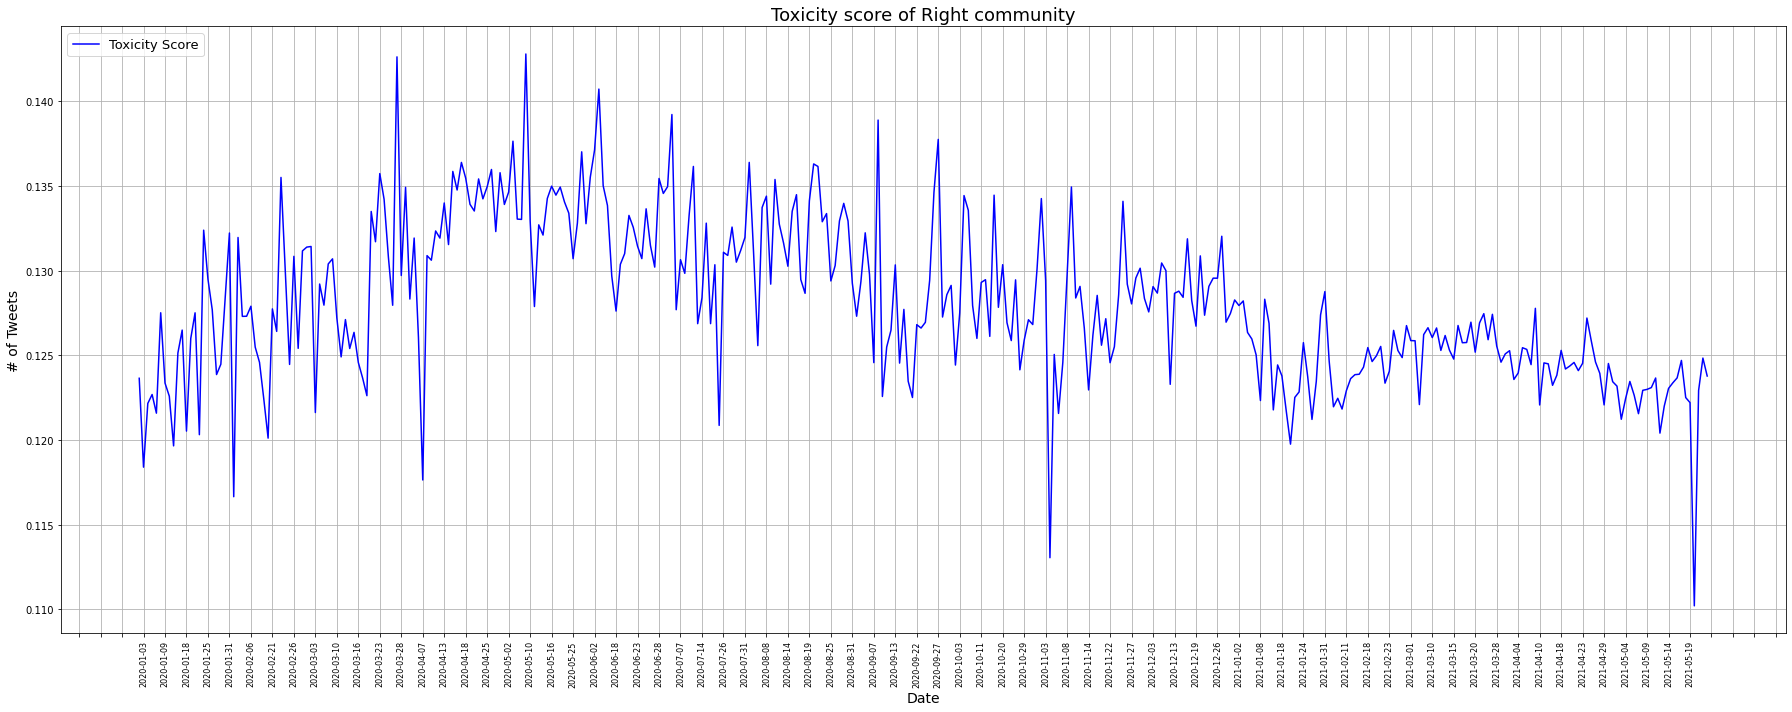

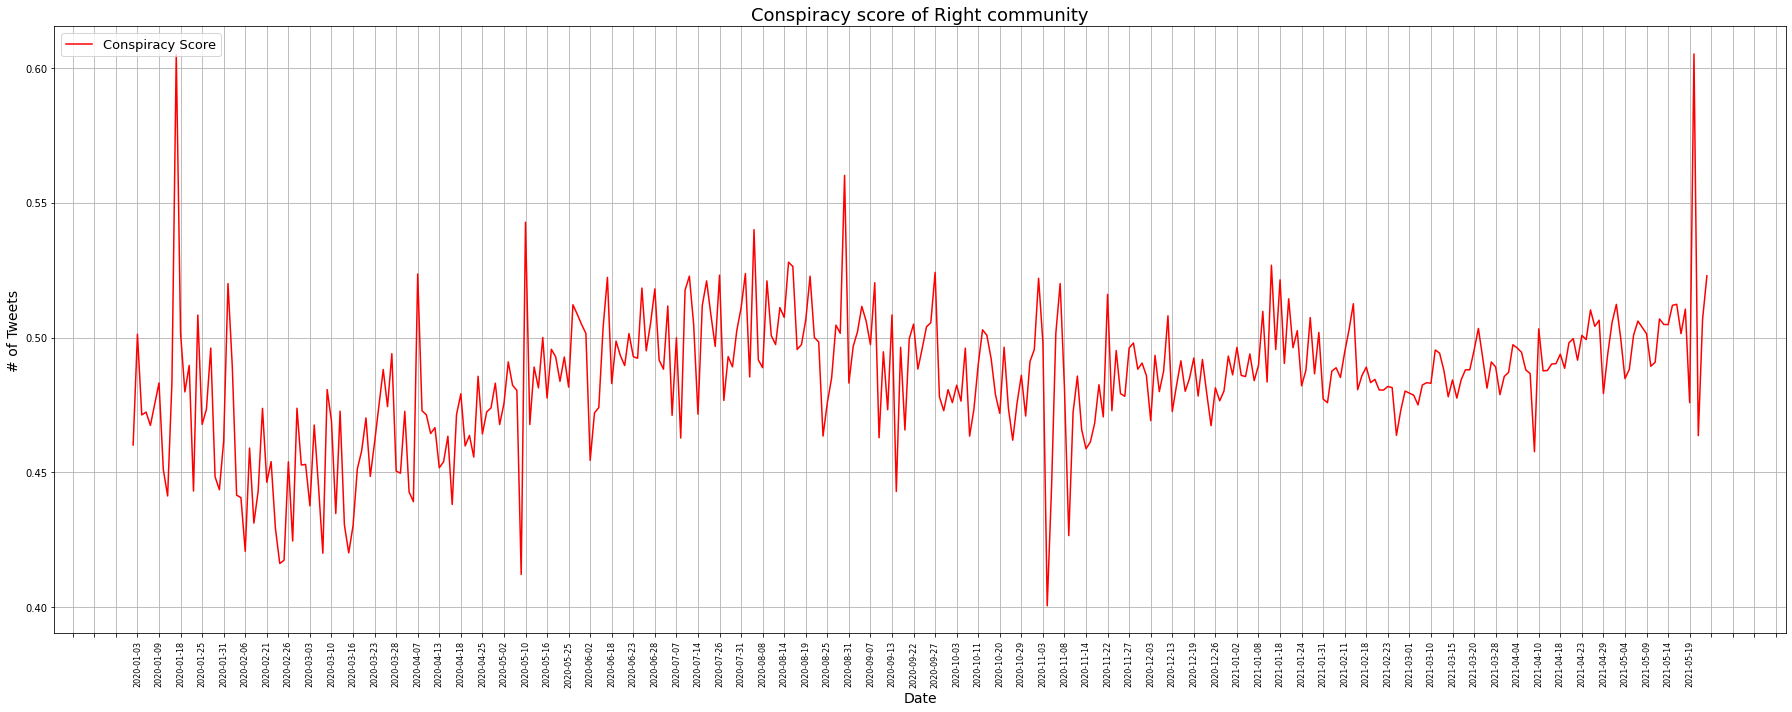

In [131]:
do_someting(merged_louvain_right, "Right community")

# Left-based

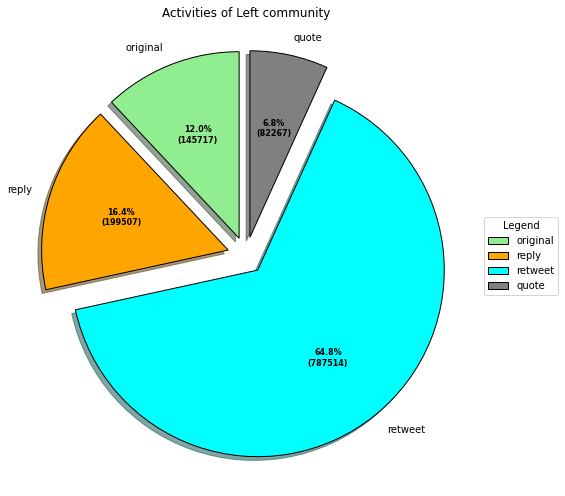

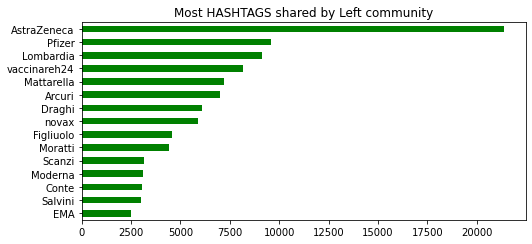

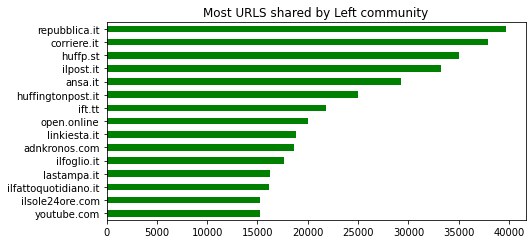

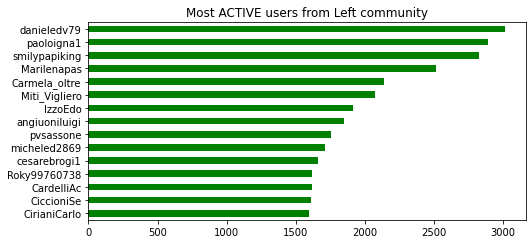

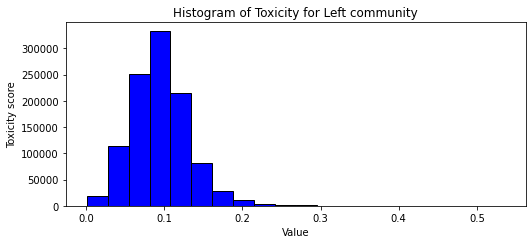

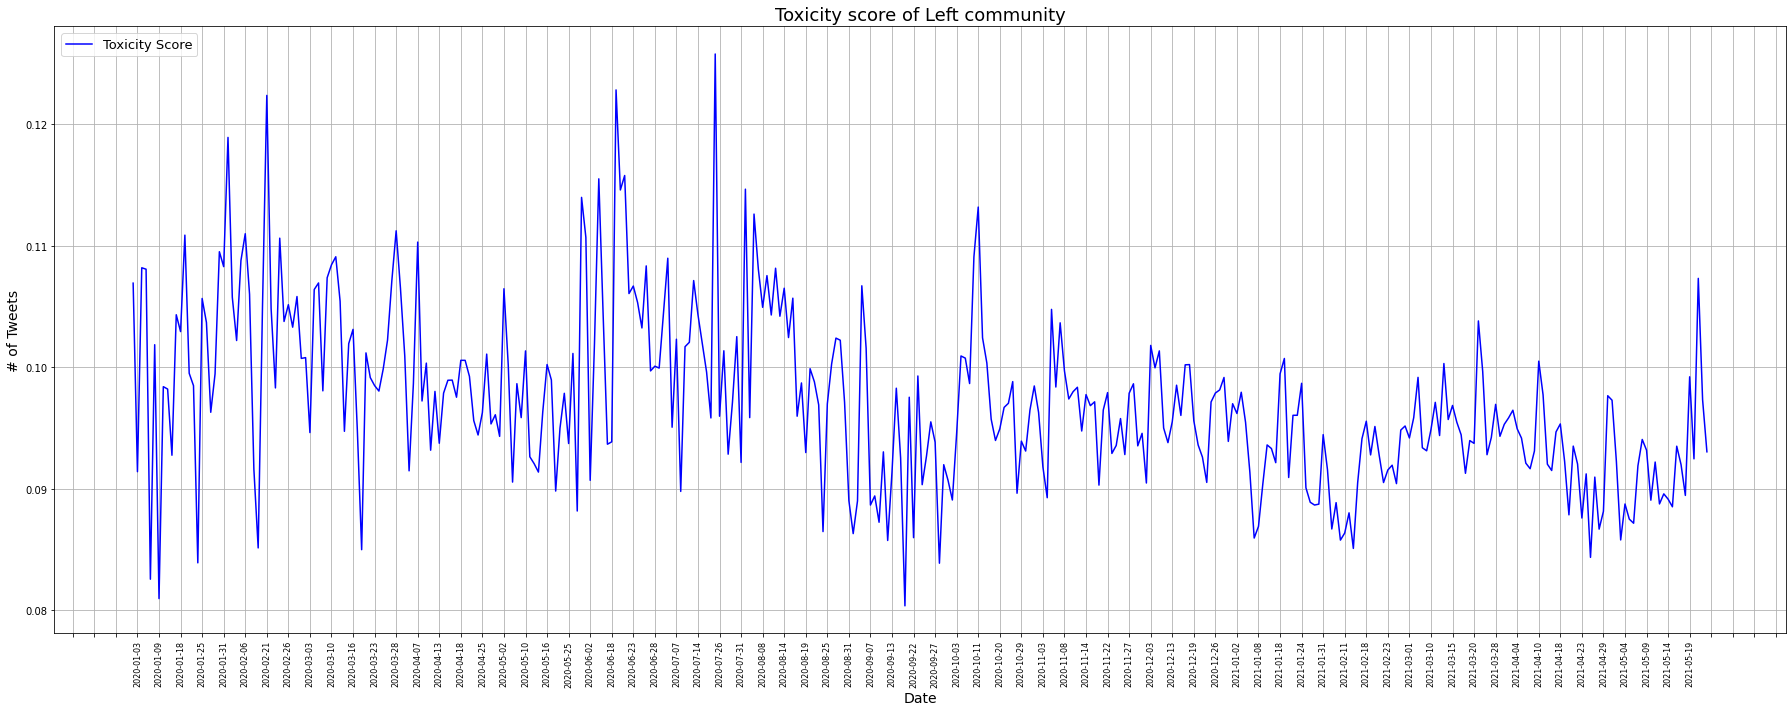

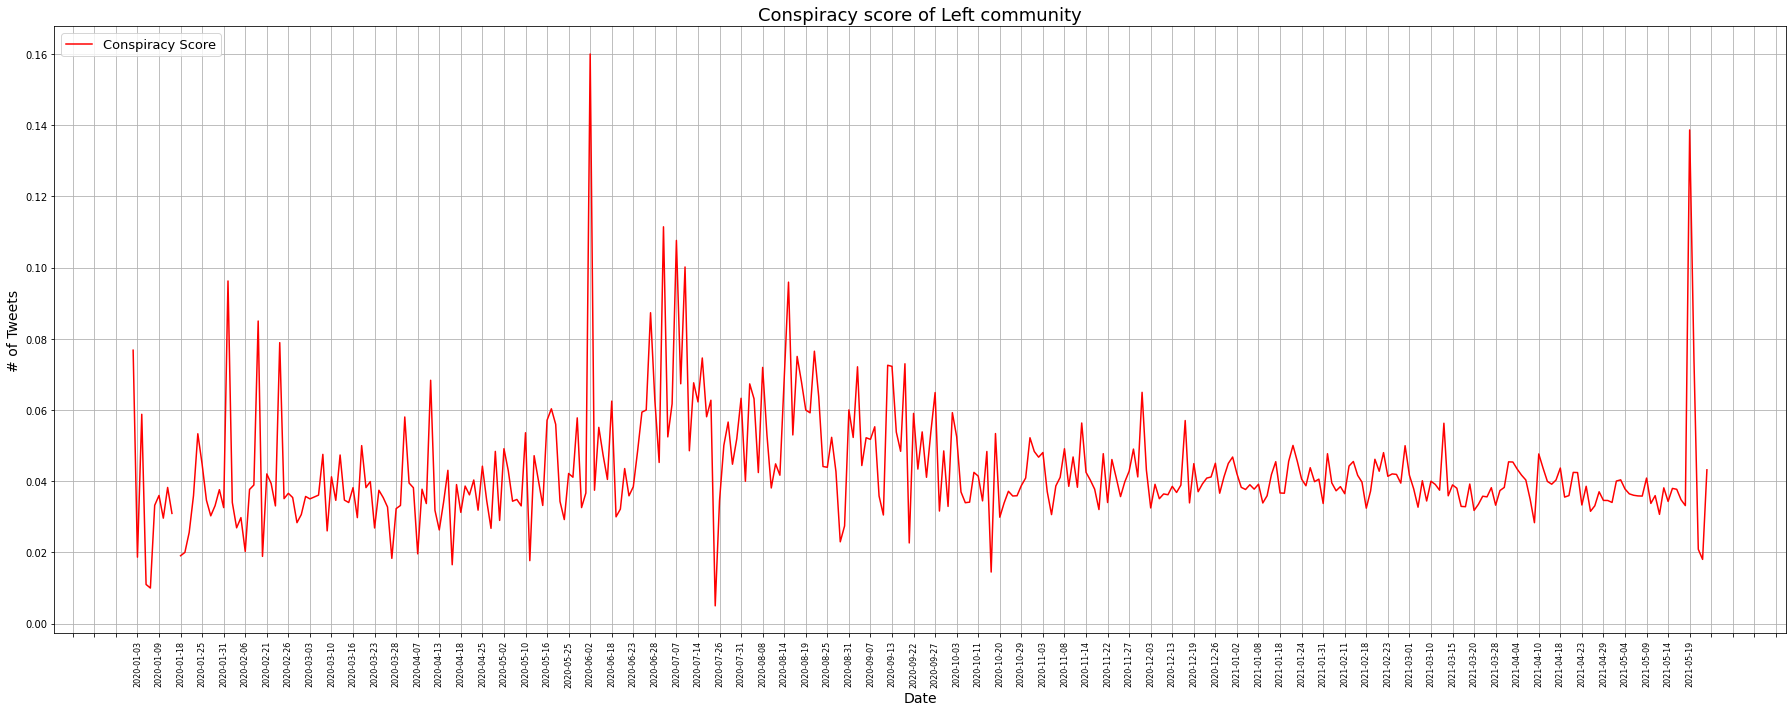

In [132]:
do_someting(merged_louvain_left, "Left community")

 # Influencer-based

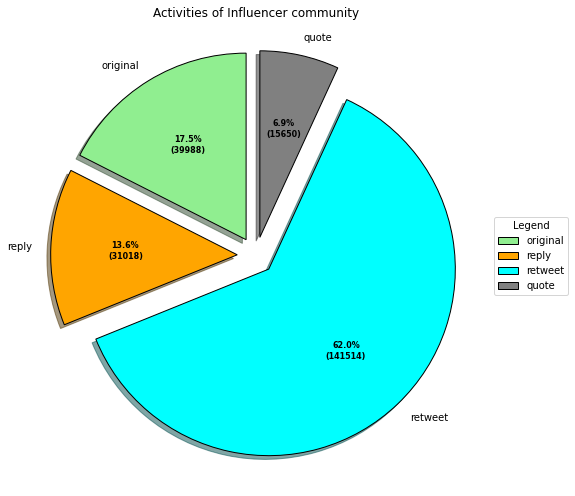

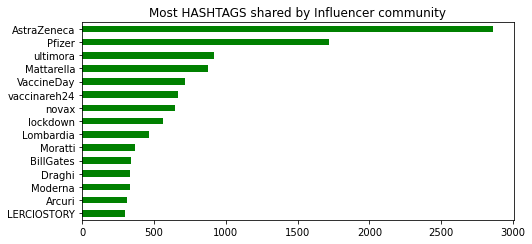

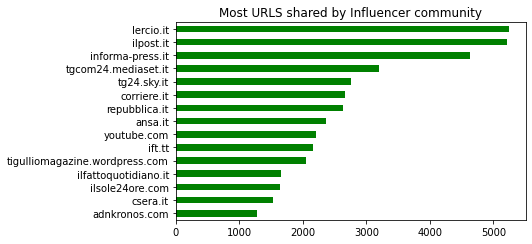

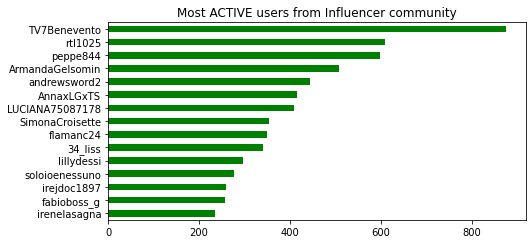

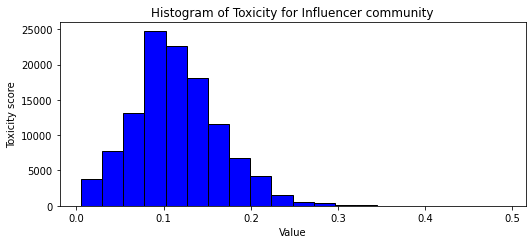

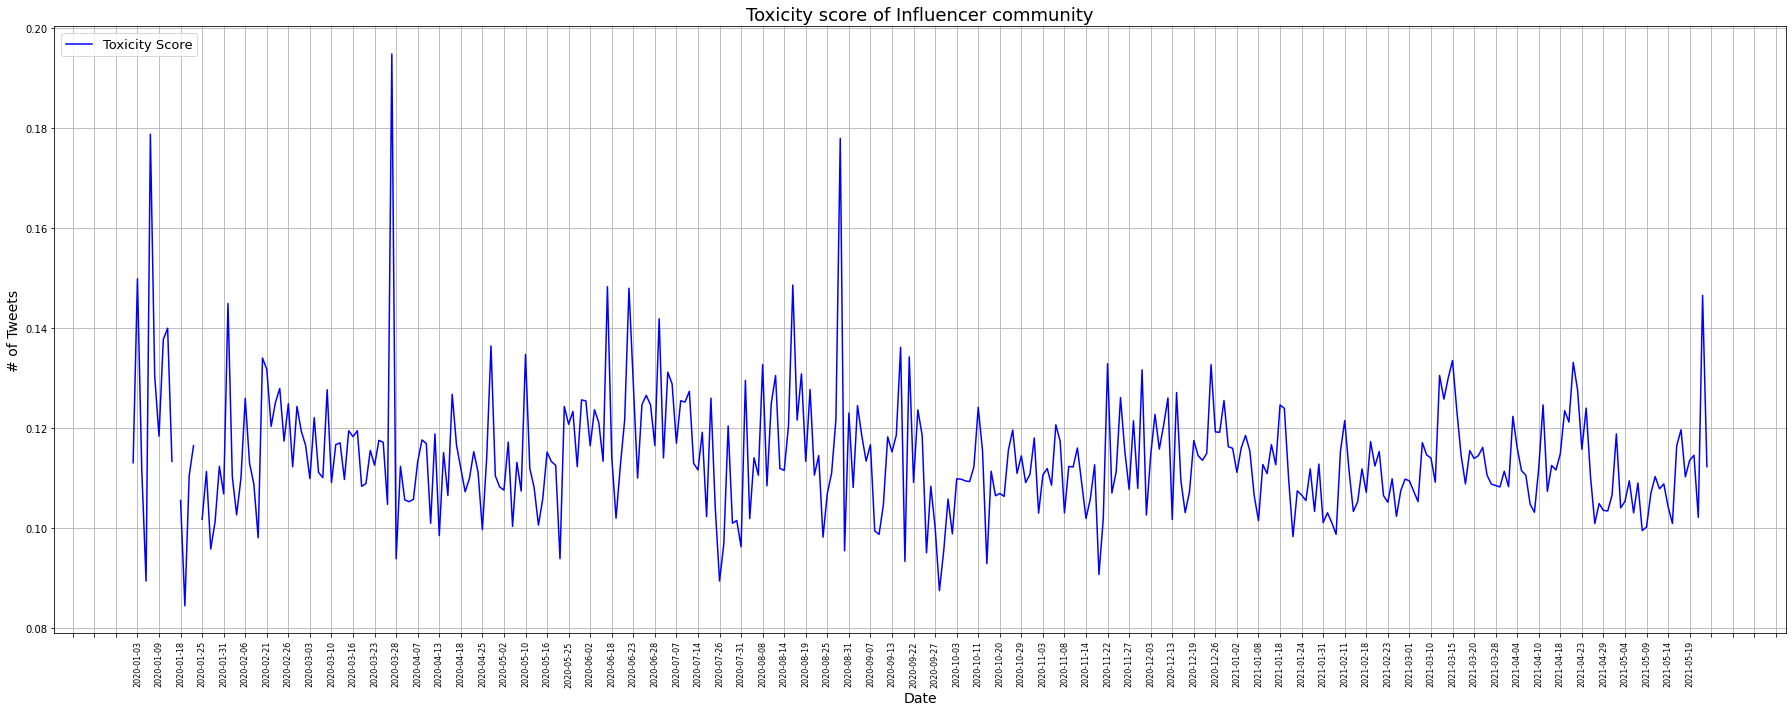

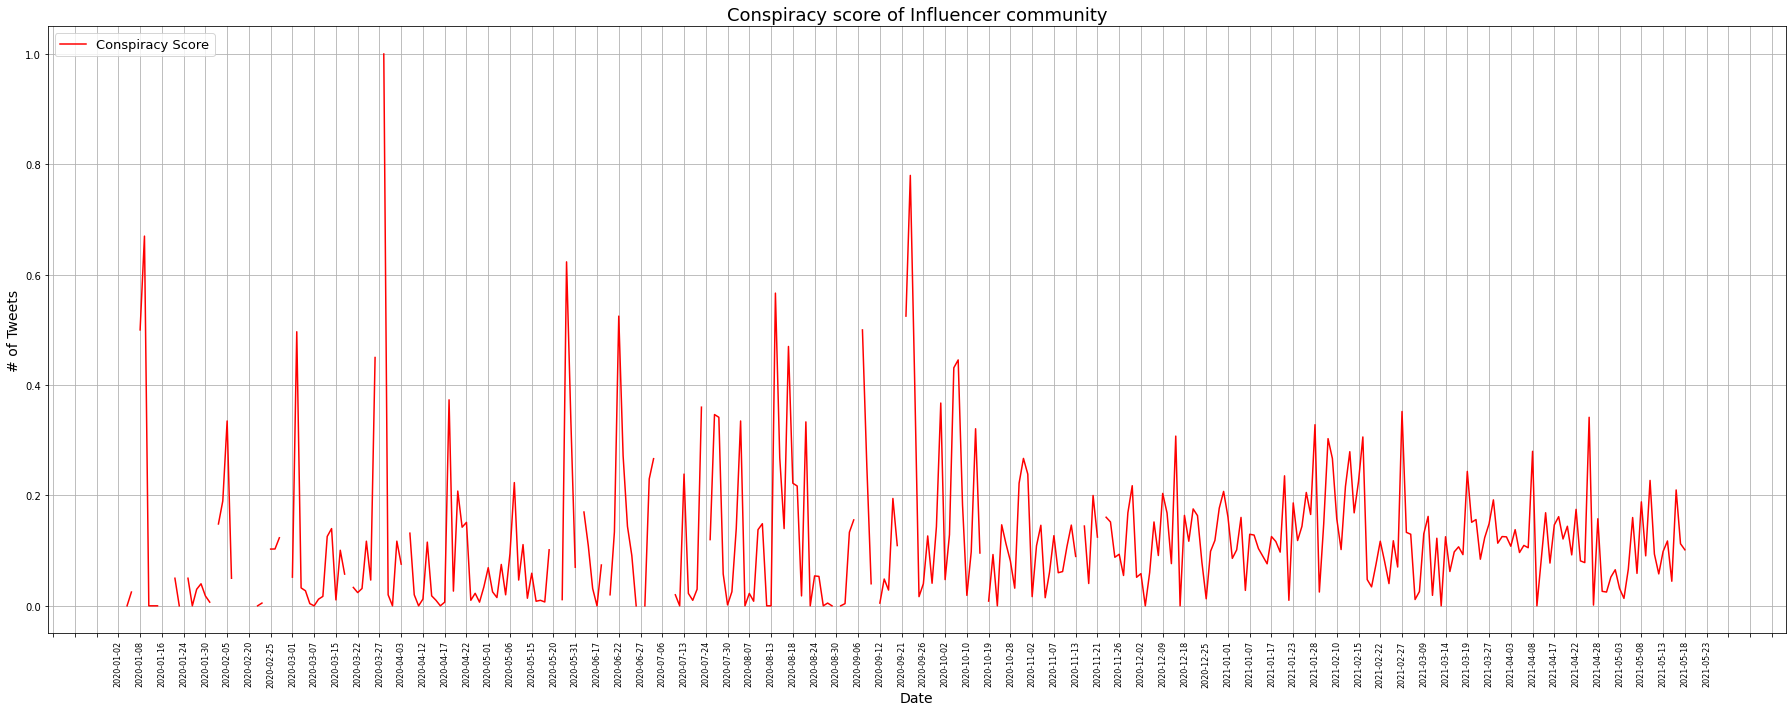

In [133]:
do_someting(merged_louvain_influencer, "Influencer community")

# Newspaper-based

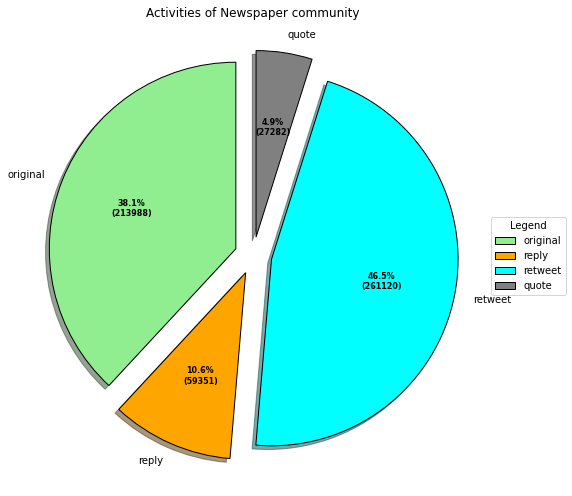

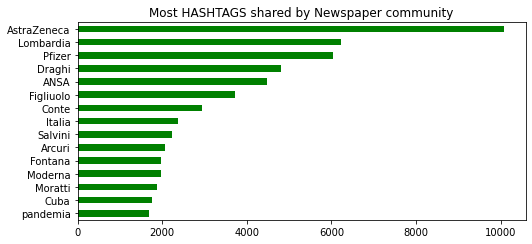

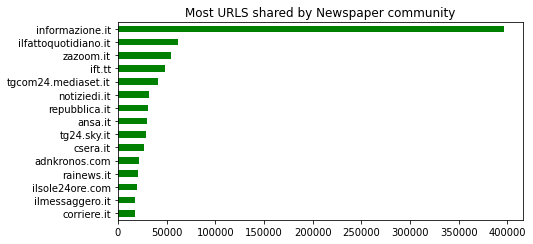

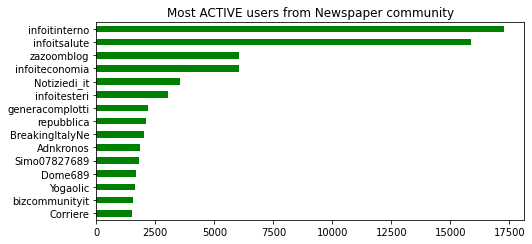

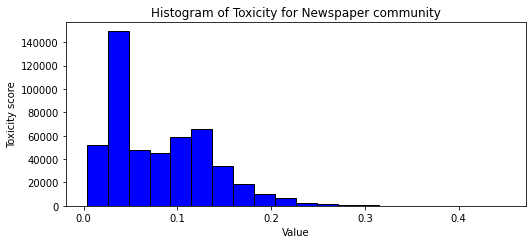

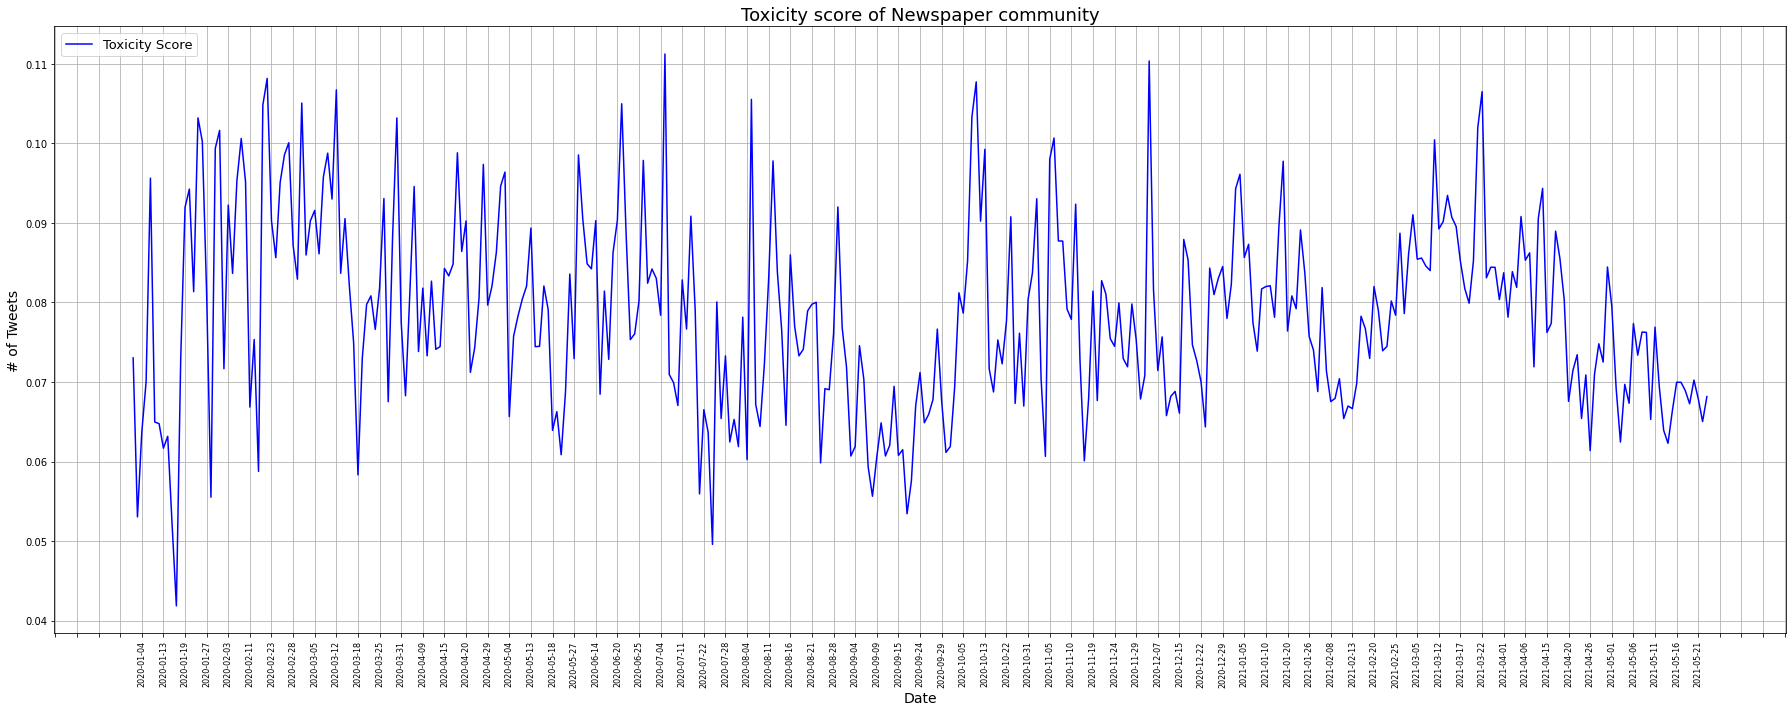

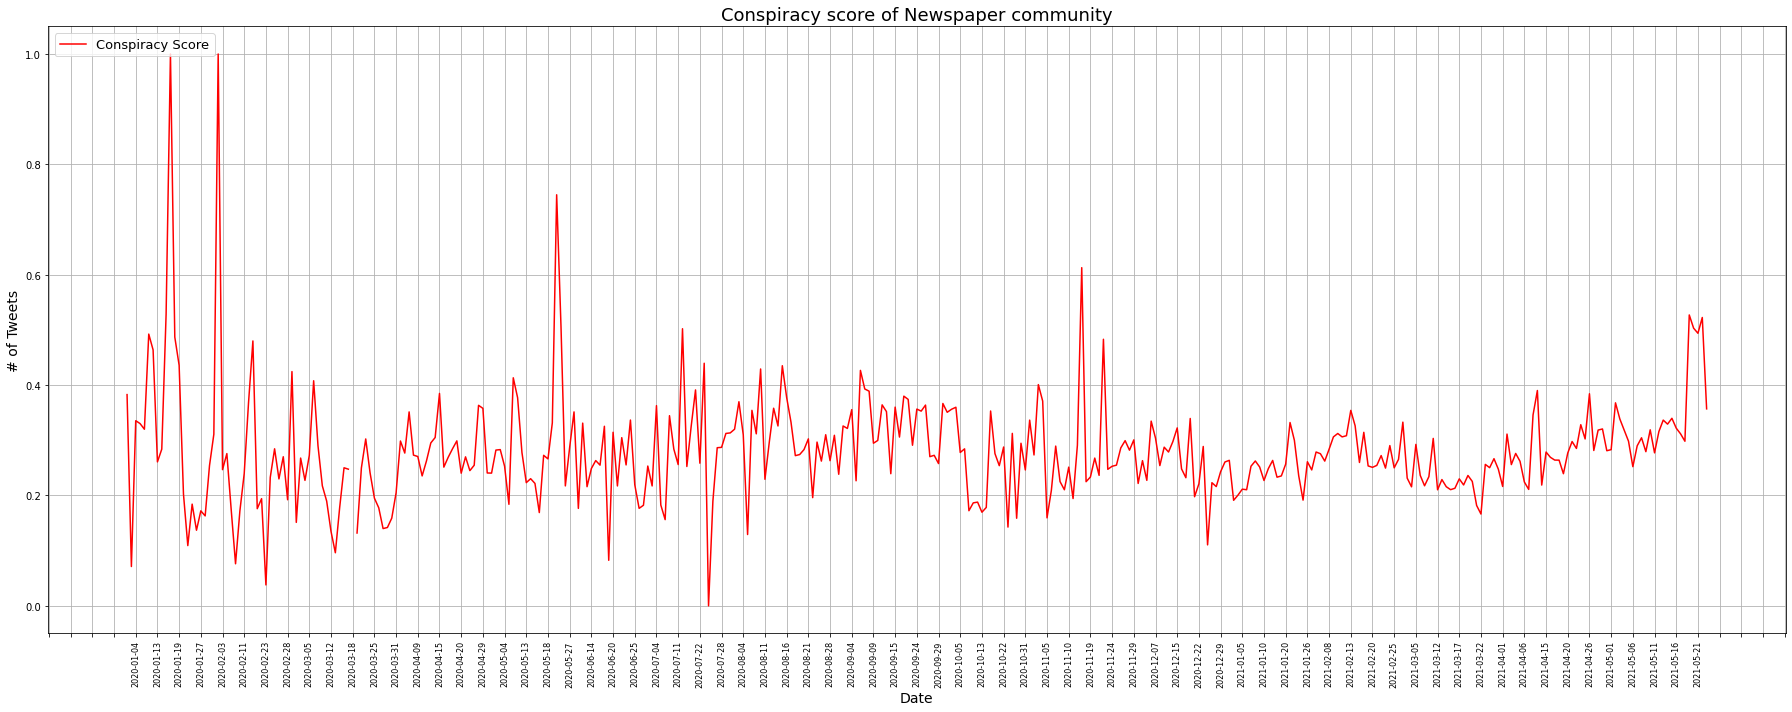

In [134]:
do_someting(merged_louvain_newspaper, "Newspaper community")

# Conspiracy score

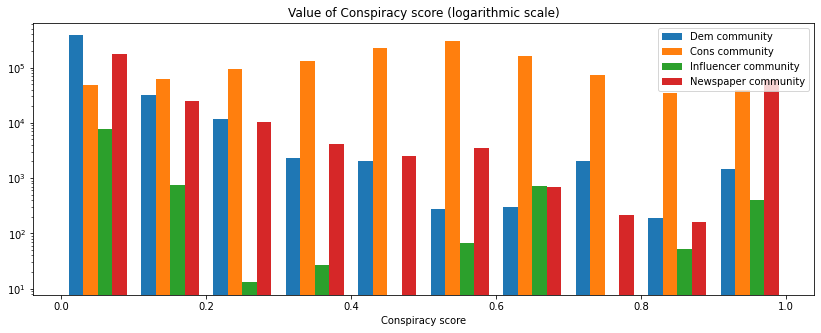

In [34]:
plt.hist([merged_louvain_left["conspiracy_score"],
          merged_louvain_right["conspiracy_score"],
          merged_louvain_influencer["conspiracy_score"],
          merged_louvain_newspaper["conspiracy_score"]],
          label=['Dem community', 'Cons community', "Influencer community", "Newspaper community"])
plt.legend(loc='upper right')
plt.title("Value of Conspiracy score (logarithmic scale)")
plt.yscale('log', nonposy='clip')
plt.xlabel("Conspiracy score")
plt.rcParams["figure.figsize"] = (14,5)
plt.show()

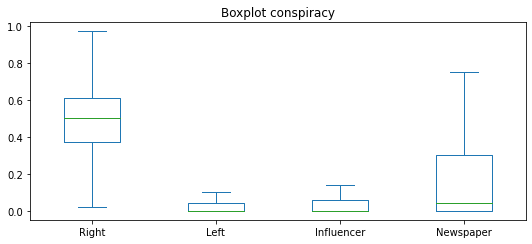

In [94]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
data = pd.DataFrame({"Right": merged_louvain_right["conspiracy_score"], "Left": merged_louvain_left["conspiracy_score"],
                    "Influencer":merged_louvain_influencer["conspiracy_score"], "Newspaper":merged_louvain_newspaper["conspiracy_score"]})

ax = data[['Right', 'Left', "Influencer", "Newspaper"]].plot(kind='box', title='Boxplot conspiracy',  showfliers=False)

# Display the plot
plt.show()

# Toxicity

In [52]:
print(np.mean(merged_louvain_right["toxicity_score"]))
print(np.mean(merged_louvain_left["toxicity_score"]))
print(np.mean(merged_louvain_influencer["toxicity_score"]))
print(np.mean(merged_louvain_newspaper["toxicity_score"]))

0.12647085841078257
0.09497238391482642
0.11556332774498121
0.08093068527929814


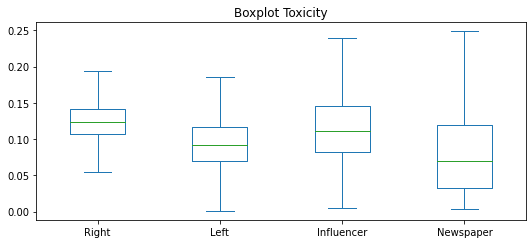

In [93]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
data = pd.DataFrame({"Right": merged_louvain_right["toxicity_score"], "Left": merged_louvain_left["toxicity_score"],
                    "Influencer":merged_louvain_influencer["toxicity_score"], "Newspaper":merged_louvain_newspaper["toxicity_score"]})

ax = data[['Right', 'Left', "Influencer", "Newspaper"]].plot(kind='box', title='Boxplot Toxicity',  showfliers=False)

# Display the plot
plt.show()